In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import matplotlib.pyplot as plt 
from collections import deque 

from vehicle_model_DDQN1 import Environment 
from cell_model import CellModel 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_id_75_110_Westinghouse.mat"
cell_model = CellModel()
env = Environment(cell_model, drving_cycle, battery_path, motor_path, 1)

In [3]:
STATE_SIZE = 4
ACTION_SIZE = env.calculation_comp["action_size"] 

In [4]:
primary_network = keras.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[STATE_SIZE],  
                       kernel_initializer=keras.initializers.he_normal()), 
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(ACTION_SIZE),
])
target_network = keras.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[STATE_SIZE],
                       kernel_initializer=keras.initializers.he_normal()), 
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(ACTION_SIZE),
])

In [5]:
def test_cycle(model_path, driving_path): 
    env = Environment(cell_model, driving_path, battery_path, motor_path, 10)
    primary_network.load_weights(model_path)
    
    
    total_reward = 0 
    state = env.reset() 
    while True: 
        action = np.argmax(primary_network(np.array(state).reshape(1, -1))) 
        next_state, reward, done = env.step(action)
        
        if done: 
            break 
            
        state = next_state
        total_reward += reward 
        
    print("Test is done...")
    print("Total reward is {:.4f}".format(total_reward))
        
    return env 
    


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Constraint error, battery current limit ( motor mode )
Constraint error, battery current limit ( motor mode )

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization1\vehicle_model_DDQN1.py:240: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization1\vehicle_model_DDQN1.py:241: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization1\vehicle_model_DDQN1.py:266: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization1\vehicle_model_DDQN1.py:267: Run


maximum steps, simulation is done ... 
Test is done...
Total reward is nan


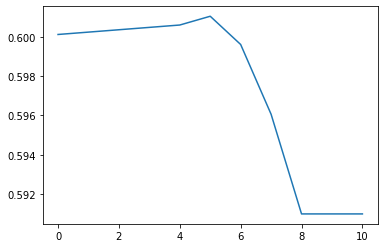

In [6]:
model_path = "./DDQN1_trial1/primary_net_checkpoint" 
driving_path = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/us06_hwy.mat'

env = test_cycle(model_path, driving_path)

plt.plot(env.history["SOC"]) 

In [7]:
def choose_action(state, primary_network, eps): 
    if random.random() < eps: 
        return random.randint(0, ACTION_SIZE - 1)
    else: 
        return np.argmax(primary_network(np.array(state).reshape(1, -1))) 

In [8]:
def train(primary_network, target_network, memory): 
    batch = memory.sample(BATCH_SIZE)
    states = np.array([val[0] for val in batch]) 
    actions = np.array([val[1] for val in batch])
    rewards = np.array([val[2] for val in batch])
    next_states = np.array([np.zeros(STATE_SIZE) if val[3] is None else val[3]  
                            for val in batch])
    
    prim_qt = primary_network(states)
    prim_qtp1 = primary_network(next_states)
    target_q = prim_qt.numpy() 
    updates = rewards 
    valid_idxs = next_states.sum(axis=1) != 0 
    batch_idxs = np.arange(BATCH_SIZE)
    prim_action_tp1 = np.argmax(prim_qtp1.numpy(), axis=1)
    q_from_target = target_network(next_states)
    updates[valid_idxs] += GAMMA * q_from_target.numpy()[batch_idxs[valid_idxs], 
                                                        prim_action_tp1[valid_idxs]]
    
    target_q[batch_idxs, actions] = updates 
    loss = primary_network.train_on_batch(states, target_q)
    return loss 
    
    
    

In [9]:
def initialization_with_rewardFactor(reward_factor):
    env = Environment(cell_model, drving_cycle, battery_path, motor_path, reward_factor)
    
    memory = Memory(10000)
    
    primary_network = keras.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=[STATE_SIZE], 
                           kernel_initializer=keras.initializers.he_normal()),
#         keras.layers.BatchNormalization(),  
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#         keras.layers.BatchNormalization(), 
        keras.layers.Dense(ACTION_SIZE),
    ])
    target_network = keras.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=[STATE_SIZE], 
                           kernel_initializer=keras.initializers.he_normal()), 
#         keras.layers.BatchNormalization(), 
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#         keras.layers.BatchNormalization(), 
        keras.layers.Dense(ACTION_SIZE),
    ])
    primary_network.compile(
        loss="mse", 
        optimizer=keras.optimizers.Adam(lr=LEARNING_RATE) 
    )
    return env, memory, primary_network, target_network 
    

In [10]:
def save_weights(primary_net, target_net, root): 
    primary_net.save_weights("./{}/primary_net_checkpoint".format(root))
    target_net.save_weights("./{}/target_net_checkpoint".format(root))
    print("model is saved..")

In [11]:
print("environment version: {}".format(env.version)) 

 
reward_factors = [10] * 2
results_dict = {} 

for trial, reward_factor in enumerate(reward_factors): 
    eps = MAX_EPSILON 
    steps = 0
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    
    env, memory, primary_network, target_network = initialization_with_rewardFactor(reward_factor)
    for episode in range(TOTAL_EPISODES): 
        state = env.reset() 
        avg_loss = 0 
        total_reward = 0
        cnt = 1 

        while True:
            action = choose_action(state, primary_network, eps)
            next_state, reward, done = env.step(action)
            total_reward += reward 
            if done: 
                next_state = None 
            memory.add_sample((state, action, reward, next_state))

            if steps > DELAY_TRAINING: 
                loss = train(primary_network, target_network, memory)
                update_network(primary_network, target_network)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * steps)
            else: 
                loss = -1

            avg_loss += loss 
            steps += 1 

            if done: 
                if steps > DELAY_TRAINING: 
                    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
                    avg_loss /= cnt 
                    print('Episode: {}'.format(episode + 1),
                          'Total reward: {}'.format(total_reward), 
                          'Explore P: {:.4f}'.format(eps), 
                          "SOC: {:.4f}".format(env.SOC), 
                         "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
                         "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
                         )
                else: 
                    print(f"Pre-training...Episode: {episode}")
                
                episode_rewards.append(total_reward)
                episode_SOCs.append(env.SOC)
                episode_FCs.append(env.fuel_consumption)
                break 

            state = next_state 
            cnt += 1 
    
    root = "DDQN1_trial{}".format(trial+2)
    save_weights(primary_network, target_network, root)
    
    results_dict[reward_factor] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs 
    }
            
    

environment version: 1


NameError: name 'MAX_EPSILON' is not defined

In [ ]:
with open("DDQN1.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open("results/replay_memory_size_effect.pkl", "rb") as f: 
#     data = pickle.load(f)
    
# data